In [18]:
import scanpy as sc
from anndata import AnnData

from grnndata import GRNAnnData, from_embeddings
from grnndata import utils 

from scdataloader import Preprocessor as myPreprocessor
from bengrn import BenGRN, get_sroy_gt, get_perturb_gt
from anndata.utils import make_index_unique

import os
import warnings
import sys
import numpy as np

sys.path.insert(0, "../")
from scgpt_helper import prepare_model, prepare_dataset, generate_embedding, generate_grn
import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.utils import set_seed
from scgpt.tokenizer import tokenize_and_pad_batch
import torch


os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

print(torch.cuda.is_available())
set_seed(42)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
True

  %reload_ext autoreload
True


In [2]:
model, vocab = prepare_model(model_dir="../save/scGPT_human")

Resume model from ../save/scGPT_human/best_model.pt, the model args will override the config ../save/scGPT_human/args.json.



In [3]:
mpreprocessor = myPreprocessor(is_symbol=True, force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)

genes = torch.load('../../scPRINT/data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']

In [4]:
NUM_GENES = 5000
MAXCELLS = 1024

In [5]:
adata = get_perturb_gt()

adata.var["isTF"] = False
adata.var.loc[adata.var.gene_name.isin(utils.TF), "isTF"] = True
adata.var["isTF"].sum()

mpreprocessor = myPreprocessor(force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)
#nadata = mpreprocessor(adata.copy())
adata


GRnnData object with n_obs × n_vars = 10691 × 8563
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'organism_ontology_term_id'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'isTF'
    varp: 'GRN'
    with a grn of 1115065 elements

In [6]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['symbol'] = adata.var["gene_name"]
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(genes) & adata.var.highly_variable]
subadata.var = subadata.var.set_index("symbol")

In [13]:
grn = generate_grn(model, vocab, subadata, batch_size = 10, num_attn_layers = 11)

100%|██████████| 103/103 [01:08<00:00,  1.50it/s]


precision:  0.020044923931586786 
recall:  1.0 
random precision: 0.020049223572069754


100%|██████████| 128/128 [00:04<00:00, 27.17it/s]


Area Under Precision-Recall Curve (AUPRC):  0.02640839280295992
EPR: 2.026399363335026


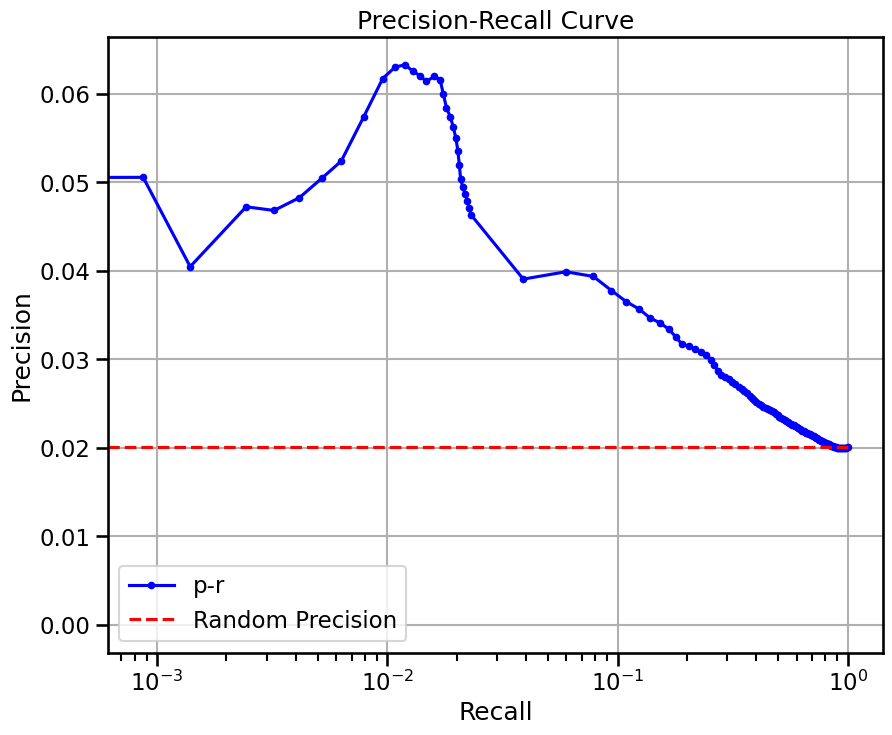

{'precision': 0.020044923931586786,
 'recall': 1.0,
 'rand_precision': 0.020049223572069754,
 'auprc': 0.02640839280295992,
 'epr': 2.026399363335026}

In [12]:
grn.varp['GRN'] = grn.varp['GRN'].T
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

precision:  0.020044923931586786 
recall:  1.0 
random precision: 0.020049223572069754


100%|██████████| 128/128 [00:04<00:00, 28.26it/s]


Area Under Precision-Recall Curve (AUPRC):  0.01725042043082372
EPR: 0.4312833559269333


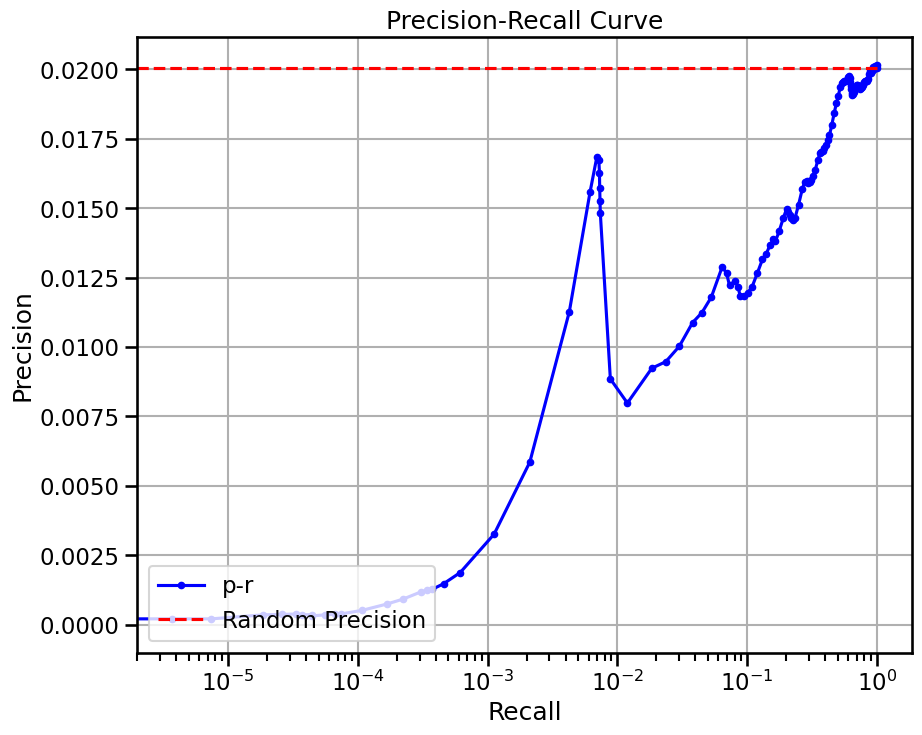

{'precision': 0.020044923931586786,
 'recall': 1.0,
 'rand_precision': 0.020049223572069754,
 'auprc': 0.01725042043082372,
 'epr': 0.4312833559269333}

In [9]:
grn.var['symbol'] = grn.var.index
grn.var = grn.var.set_index('ensembl_id')
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

base enrichment
Top central genes: []


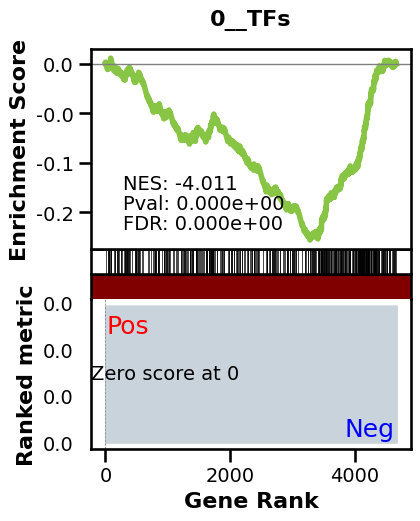

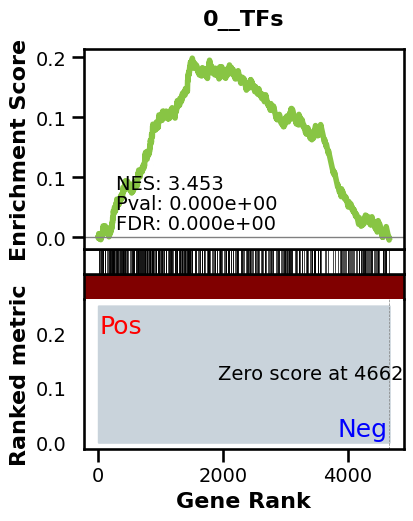

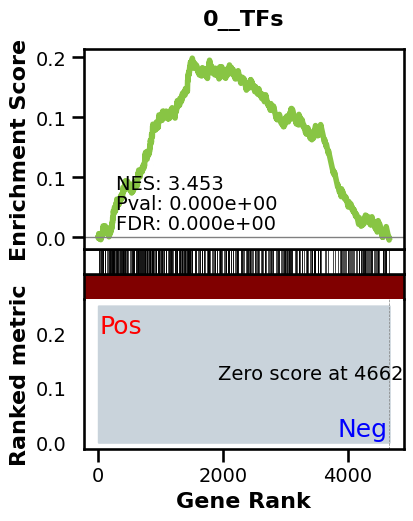

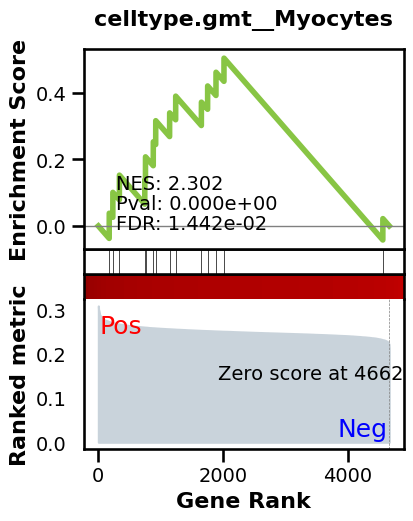

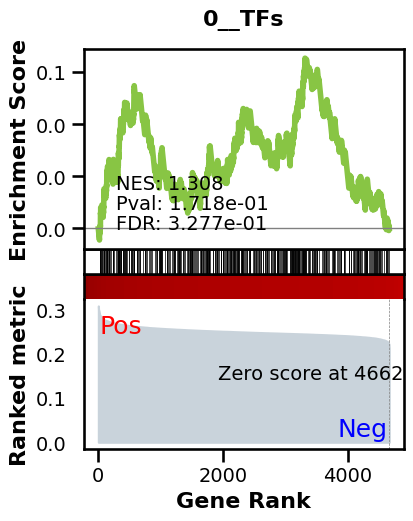

_________________________________________
TF specific enrichment
found some significant results for  14.285714285714286 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3257 genes
intersection pct: 0.6984773750804203
precision:  0.001633604545603569 
recall:  1.0 
random precision: 0.0016341061128573617


100%|██████████| 128/128 [00:02<00:00, 61.05it/s]


Area Under Precision-Recall Curve (AUPRC):  0.002076458982366535
EPR: 0.9881248964316098


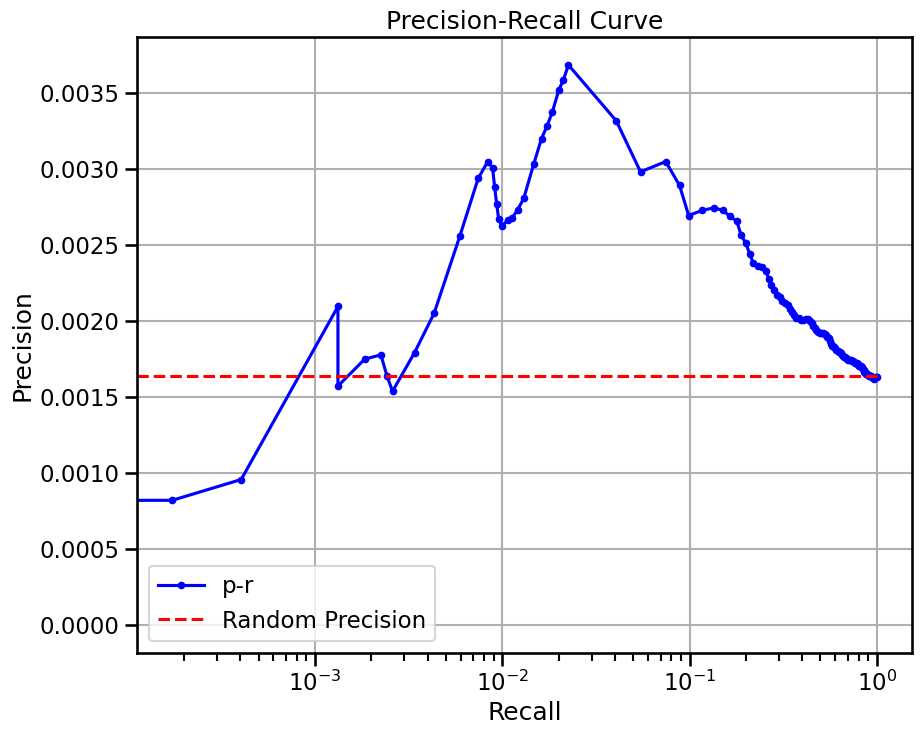

{'TF_enr': True,
 'enriched_terms_Targets': ['0__TFs'],
 'enriched_terms_Regulators': ['celltype.gmt__Myocytes',
  'celltype.gmt__Melanocytes',
  'celltype.gmt__Mesangial cells',
  'celltype.gmt__Starburst amacrine cells',
  'celltype.gmt__Granulocytes',
  'celltype.gmt__Glycinergic amacrine cells',
  'celltype.gmt__Non-classical monocytes'],
 'significant_enriched_TFtargets': 14.285714285714286,
 'precision': 0.001633604545603569,
 'recall': 1.0,
 'rand_precision': 0.0016341061128573617,
 'auprc': 0.002076458982366535,
 'epr': 0.9881248964316098}

: 

In [19]:
grn.var.index = make_index_unique(grn.var['symbol'].astype(str))
BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()